In [ ]:
# Устанавливаем дополнительные библиотеки, которых нет в стандартной среде Kaggle
!pip install clearml

In [ ]:
# Настраиваем окружение ClearML
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=''
%env CLEARML_API_SECRET_KEY=''

In [ ]:
# Импортируем необходимые библиотеки
import re
import random
import numpy as np
import pandas as pd
import csv
from typing import List, Dict, Callable
import torch
import torch.nn as nn
from torch.utils.data import Dataset as TorchDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from gensim.models import Word2Vec
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from clearml import Task, Logger, Dataset
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Централизованная конфигурация для всего пайплайна
class Config:

    # Общие
    SEED = 42
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Данные
    TEST_SIZE = 0.2
    MAX_LEN = 64 
    
    # Токенизация
    VOCAB_SIZE = 20000  
    EMBEDDING_DIM = 100
    
    # Word2Vec
    W2V_WINDOW = 5
    W2V_MIN_COUNT = 2
    W2V_WORKERS = 4
    W2V_EPOCHS = 5
    
    # Параметрв модели
    HIDDEN_SIZE = 96 
    BANK_EMBED_DIM = 12  
    DROPOUT = 0.55 
    NUM_CLASSES = 3
    GRU_LAYERS = 1  
    
    # Обучение
    BATCH_SIZE = 32
    BANKS_EPOCHS = 15
    SENTIMENT_EPOCHS = 13  
    LEARNING_RATE = 1e-3 
    LEARNING_RATE_BA = 1.5e-4  
    GRADIENT_CLIP = 0.3  
    WEIGHT_DECAY = 1.5e-2  

    # Инференс
    BANK_THRESHOLD = 0.2
    
    # Банки и метки
    BANK_TARGETS = ['sber', 'vtb', 'gazprom', 'alfabank', 'raiffeisen', 'rshb', 'company']
    SENTIMENT_LABELS = {-1: 0, 0: 1, 1: 2}
    LABELS_TO_SENTIMENT = {0: -1, 1: 0, 2: 1}
    
    # Специальные токены
    SPECIAL_TOKENS = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]


# Фиксация сидов для воспроизводимости
def set_seed(seed: int = Config.SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()

In [ ]:
# Проверка устройства
device = torch.device(Config.DEVICE)
print(f"Используется устройство: {device}")

Используется устройство: cuda


In [ ]:
# Находим датасет в ClearML
dataset = Dataset.get('2a542c96a0de46b0bc8b4977bf536180')
print(dataset.list_files())

# Скачиваем датасет в локальный кеш, чтобы дальше работать с файлами как с обычными CSV
local_path = dataset.get_local_copy() 

['sample_submission.csv', 'test.csv', 'train.csv']


In [ ]:
# Читаем обучающую выборку
orig_df = pd.read_csv(f'{local_path}/train.csv',sep=";",quoting=csv.QUOTE_NONE, na_values=['NULL'])
orig_df['text'] = orig_df['text'].fillna('')
orig_df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,text,sber,vtb,gazprom,alfabank,raiffeisen,rshb,company
0,8292,"#novosti Сбербанк и ВТБ пообещали выполнить обязательства перед клиентами: Банки, попавшие под санкции Евросою...",1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,10897,Корея может стать следующей Японией для инвесторов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3964,#Новые санкции затрагивают и Газпромбанк #sledui,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
3,11829,VEON заявила об обесценивании бизнеса в России на $449 млн в I квартале,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
4,18814,банк втб ипотечный кредит,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
7178,3721,У твиттера Сбербанка 42 тыс.читателейВТБ13 тыс.,0.0,0.0,NaN,NaN,NaN,NaN,NaN
7179,18578,заместителя руководителя пошёл на повышение клиентский менеджер в сбербанк премьер г,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7180,91,Оформить кредитную карту альфа банк,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7181,14728,Кредиты малого бизнеса втб 24 г иркутск,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Инициализируем удаленную таску
task = Task.init(
        project_name="sentiment_analysis_kaggle_mllabs",
        task_name="two_GRU_models_final",
        task_type="training",
)
task:Task

# Получаем логгер для последующего логирования метрик и артефактов
log = Logger.current_logger()


ClearML Task: created new task id=c8301c0f2f8f4f7893eca45ed6e4fd72


Jupyter Notebook auto-logging failed, could not access: /kaggle/working/__notebook_source__.ipynb
2025-10-28 15:37:49.678450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761665869.704147     315 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761665869.712052     315 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ClearML results page: https://app.clear.ml/projects/35dce4e49e9f40338a35c4602091839f/experiments/c8301c0f2f8f4f7893eca45ed6e4fd72/output/log


In [ ]:
# Разбиваем на train/test

train_df, test_df = train_test_split(
    orig_df,
    test_size=Config.TEST_SIZE,
    random_state=Config.SEED
)
print(f"Train: {len(train_df)} примеров, Test: {len(test_df)} примеров")

Train: 5746 примеров, Test: 1437 примеров


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



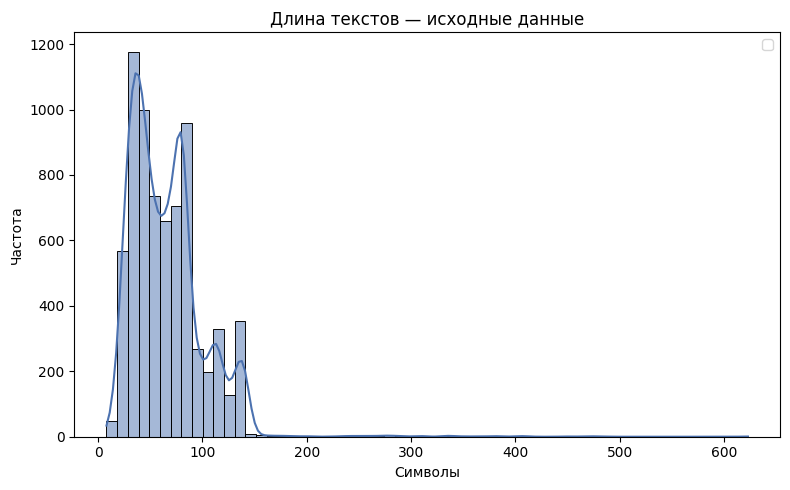

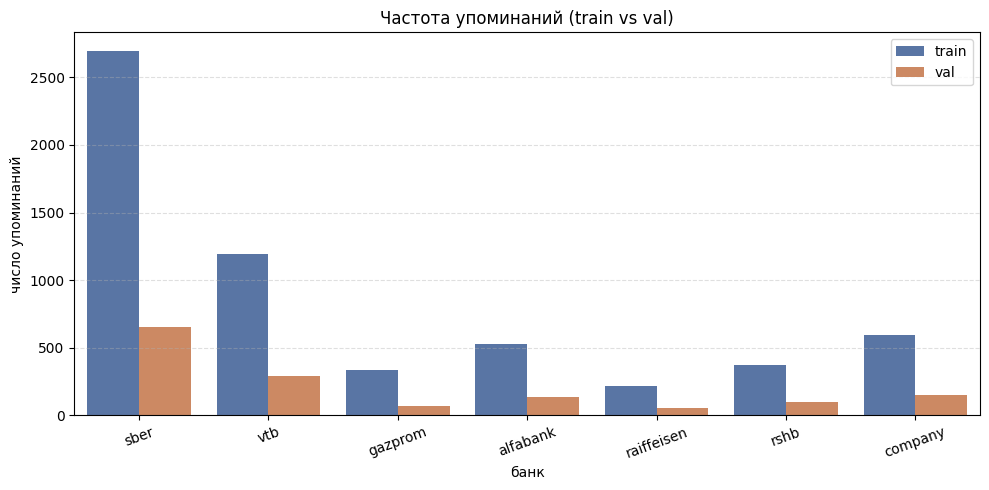

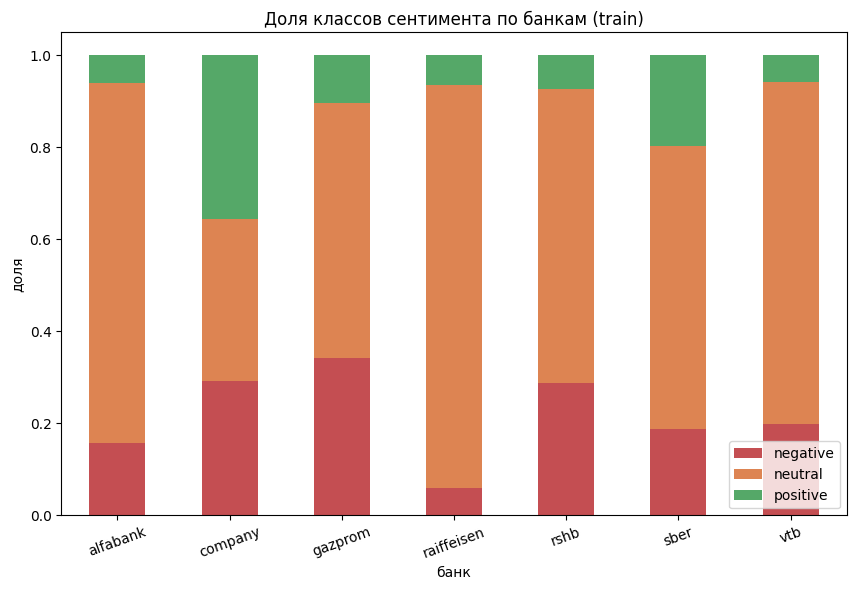

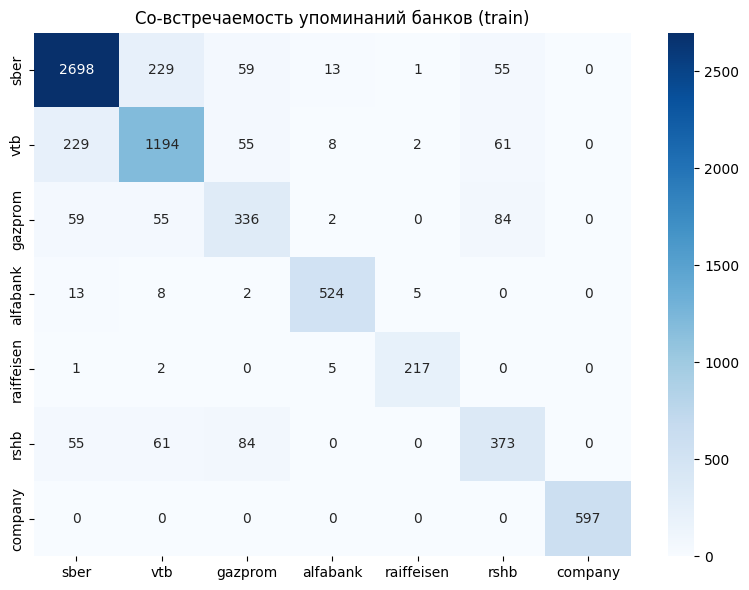

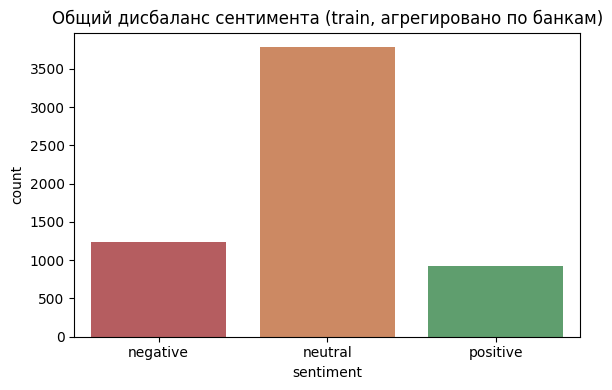

In [ ]:
# Разведочный анализ: сначала смотрим длину текстов, чтобы настраивать MAX_LEN
orig_text_len = orig_df['text'].astype(str).str.len()
plt.figure(figsize=(8,5))
sns.histplot(orig_text_len, bins=60, kde=True, color="#4c72b0")
plt.title("Длина текстов — исходные данные")
plt.xlabel("Символы")
plt.ylabel("Частота")
plt.tight_layout()
plt.show()

# Проверяем, насколько распределение банков сопоставимо между train/val
banks = Config.BANK_TARGETS
train_counts = train_df[banks].notna().sum().reindex(banks).astype(int)
val_counts   = test_df[banks].notna().sum().reindex(banks).astype(int)

bar_df = pd.DataFrame({
    "bank": banks,
    "train": train_counts.values,
    "val": val_counts.values,
}).melt(id_vars=["bank"], value_vars=["train", "val"],
       var_name="split", value_name="count")

fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(
    data=bar_df, x="bank", y="count", hue="split",
    hue_order=["train", "val"],
    palette={"train": "#4c72b0", "val": "#dd8452"},
    ax=ax
)

ax.legend(["train", "val"], title="split")
ax.set_title("Частота упоминаний (train vs val)")
ax.set_xlabel("банк")
ax.set_ylabel("число упоминаний")
plt.xticks(rotation=20)
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Для каждой компании смотрим баланс классов сентимента
rows = []
for b in banks:
    s = train_df[train_df[b].notna()][b]
    rows.append({
        "bank": b,
        "negative": (s == -1).sum(),
        "neutral": (s == 0).sum(),
        "positive": (s == 1).sum(),
        "total": len(s)
    })
stat_df = pd.DataFrame(rows)
long_df = stat_df.melt(id_vars=["bank", "total"], value_vars=["negative", "neutral", "positive"],
                       var_name="sentiment", value_name="count")

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
base = pd.pivot_table(long_df, index="bank", columns="sentiment", values="count", fill_value=0)
base = base[["negative", "neutral", "positive"]]
base.div(base.sum(axis=1), axis=0).plot(kind="bar", stacked=True, ax=ax,
                                        color=["#c44e52", "#dd8452", "#55a868"])
ax.set_title("Доля классов сентимента по банкам (train)")
ax.set_xlabel("банк")
ax.set_ylabel("доля")
plt.xticks(rotation=20)
plt.legend(title="sentiment", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Строим матрицу со-встречаемости, чтобы понять, кого часто упоминают вместе
cooc = pd.DataFrame(0, index=banks, columns=banks, dtype=int)
train_presence = train_df[banks].notna().astype(int).values
for i, bi in enumerate(banks):
    for j, bj in enumerate(banks):
        if j >= i:
            cooc.iloc[i, j] = int((train_presence[:, i] & train_presence[:, j]).sum())
            cooc.iloc[j, i] = cooc.iloc[i, j]

plt.figure(figsize=(8, 6))
sns.heatmap(cooc, annot=True, fmt="d", cmap="Blues")
plt.title("Со-встречаемость упоминаний банков (train)")
plt.tight_layout()
plt.show()

# Наконец, оцениваем общий дисбаланс тональностей, чтобы подобрать веса
sentiment_map = {-1: "negative", 0: "neutral", 1: "positive"}
all_labels = []
for b in banks:
    s = train_df[train_df[b].notna()][b]
    all_labels.extend(s.values.tolist())
all_labels = pd.Series(all_labels)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(x=all_labels.map(sentiment_map), order=["negative", "neutral", "positive"],
              palette=["#c44e52", "#dd8452", "#55a868"], ax=ax)
ax.set_title("Общий дисбаланс сентимента (train, агрегировано по банкам)")
ax.set_xlabel("sentiment")
ax.set_ylabel("count")
plt.tight_layout()
plt.show()


In [ ]:
# Выполняем токенизацию и предобработку

CLEANUP_PATTERN = re.compile(r"[0-9!#$%&'()*+,./:;<=>?[\\]^_`{|}~—\"\-]+")

# Обучаем WordPiece токенизатор на корпусе текстов
def train_wordpiece_tokenizer(texts: List[str], vocab_size: int = Config.VOCAB_SIZE) -> Tokenizer:

    tok = Tokenizer(WordPiece(unk_token="[UNK]"))
    tok.pre_tokenizer = Whitespace()
    trainer = WordPieceTrainer(
        vocab_size=vocab_size, 
        special_tokens=Config.SPECIAL_TOKENS
    )
    tok.train_from_iterator(texts, trainer)
    return tok

# Токенизируем текст с предварительной очисткой
def wp_tokenize(text: str, tokenizer: Tokenizer) -> List[str]:
    clean = CLEANUP_PATTERN.sub(" ", str(text).lower())
    return tokenizer.encode(clean).tokens


In [ ]:
# Собираем тексты
all_texts = pd.concat([train_df['text'], test_df['text']], axis=0).astype(str).tolist()

# Обучаем токенизатор
wp_tokenizer = train_wordpiece_tokenizer(all_texts, vocab_size=Config.VOCAB_SIZE)
print(f"Токенизатор обучен. Размер словаря: {wp_tokenizer.get_vocab_size()}")

# Токенизация для Word2Vec
sentences = [wp_tokenize(t, wp_tokenizer) for t in all_texts]

# Обучаем Word2Vec
w2v = Word2Vec(
    sentences=sentences, 
    vector_size=Config.EMBEDDING_DIM, 
    window=Config.W2V_WINDOW, 
    min_count=Config.W2V_MIN_COUNT, 
    workers=Config.W2V_WORKERS, 
    sg=1, 
    epochs=Config.W2V_EPOCHS
)
print(f"Word2Vec обучен. Векторов в модели: {len(w2v.wv)}")

# Извлекаем ID специальных токенов
pad_id = wp_tokenizer.token_to_id("[PAD]")
cls_id = wp_tokenizer.token_to_id("[CLS]")
sep_id = wp_tokenizer.token_to_id("[SEP]")
vocab_size = wp_tokenizer.get_vocab_size()

# Создаём матрицу эмбеддингов
embedding_matrix = np.random.normal(0, 0.02, size=(vocab_size, Config.EMBEDDING_DIM)).astype(np.float32)

# Заполняем векторами из Word2Vec
w2v_coverage = 0
for token, idx in wp_tokenizer.get_vocab().items():
    if token in w2v.wv:
        embedding_matrix[idx] = w2v.wv[token]
        w2v_coverage += 1

# Zero-вектор для PAD
if pad_id is not None:
    embedding_matrix[pad_id] = 0.0





Токенизатор обучен. Размер словаря: 20000
Word2Vec обучен. Векторов в модели: 7232


In [ ]:
# Создаем функцию для кодирования текста в последовательность токенов с [CLS] и [SEP]
def encode_text(text: str) -> List[int]:
    clean = CLEANUP_PATTERN.sub(" ", str(text).lower())
    encoding = wp_tokenizer.encode(clean)
    ids = [cls_id] + encoding.ids[:Config.MAX_LEN-2] + [sep_id]
    if len(ids) < Config.MAX_LEN:
        ids = ids + [pad_id] * (Config.MAX_LEN - len(ids))  # Паддингом выравниваем батчи внутри DataLoader
    return ids[:Config.MAX_LEN]

# Датасет для определения упомянутых банков (multi-label classification)
class BanksDataset(TorchDataset):
    
    def __init__(self, df: pd.DataFrame):
        self.texts = df['text'].values
        # Предварительно извлекаем все метки банков
        self.labels = df[Config.BANK_TARGETS].values
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx: int):
        text = self.texts[idx]
        labels = self.labels[idx]
        
        x = torch.tensor(encode_text(text), dtype=torch.long)
        # Преобразуем в 0 или 1
        y = torch.tensor([1 if pd.notna(l) else 0 for l in labels], dtype=torch.float32)
        return x, y 

# Датасет для классификации сентимента
class BankAwareSentimentDataset(TorchDataset):
    
    def __init__(self, df: pd.DataFrame):
        self.data = []
        
        for bank_idx, bank_name in enumerate(Config.BANK_TARGETS):
            mask = df[bank_name].notna()
            if mask.sum() > 0:
                bank_df = df[mask]
                for text, sentiment in zip(bank_df['text'].values, bank_df[bank_name].values):
                    self.data.append((
                        text, 
                        bank_idx, 
                        Config.SENTIMENT_LABELS[int(sentiment)]
                    )) 
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx: int):
        text, bank_idx, label = self.data[idx]
        x = torch.tensor(encode_text(text), dtype=torch.long)
        bank = torch.tensor(bank_idx, dtype=torch.long)
        y = torch.tensor(label, dtype=torch.long)
        return x, bank, y 

In [ ]:
# Создаем модели

# Multi-label классификатор для определения упомянутых банков
class GRUMultiLabel(nn.Module):
    
    def __init__(self, vocab_size: int, embed_dim: int, hidden_size: int, 
                 num_labels: int, embedding_matrix: np.ndarray, 
                 dropout: float = Config.DROPOUT):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))  # Стартуем с предобученных W2V весов
        self.embedding.weight.requires_grad = True  # Разрешаем дальнейшее дообучение под задачу
        
        self.gru = nn.GRU(embed_dim, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_labels)
    
    def forward(self, x):
        # x: (batch_size, seq_len)
        emb = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        out, _ = self.gru(emb)  # (batch_size, seq_len, hidden_size*2)
        lengths = (x != pad_id).sum(dim=1) - 1  # (batch_size,) - берём эмбеддинг последнего непаддингового токена
        h = out[torch.arange(out.size(0)), lengths, :]  # (batch_size, hidden_size*2)
        h = self.dropout(h)
        logits = self.fc(h)  # (batch_size, num_labels)
        return logits

# Классификатор сентимента
class BankAwareGRUClassifier(nn.Module):
   
    def __init__(self, vocab_size: int, embed_dim: int, hidden_size: int, 
                 num_classes: int, num_banks: int, bank_embed_dim: int, 
                 embedding_matrix: np.ndarray, dropout: float = Config.DROPOUT):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_id)
        self.embedding.weight.data.copy_(torch.tensor(embedding_matrix))  
        self.embedding.weight.requires_grad = True
        self.emb_dropout = nn.Dropout(0.2) 
        self.bank_embedding = nn.Embedding(num_banks, bank_embed_dim)
        
        self.gru = nn.GRU(embed_dim, hidden_size, num_layers=Config.GRU_LAYERS, 
                         batch_first=True, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2 + bank_embed_dim, num_classes)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
    
    def forward(self, x, bank_idx):
        # x: (batch_size, seq_len)
        # bank_idx: (batch_size,)
        emb = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        emb = self.emb_dropout(emb)

        out, _ = self.gru(emb)  # (batch_size, seq_len, hidden_size*2)
        mask = (x != pad_id).unsqueeze(-1).float()  # (batch_size, seq_len, 1)
        masked_out = out * mask  # (batch_size, seq_len, hidden_size*2)
        sum_out = masked_out.sum(dim=1)  # (batch_size, hidden_size*2)
        lengths = mask.sum(dim=1).clamp(min=1)  # (batch_size, 1)

        h = sum_out / lengths  # (batch_size, hidden_size*2)
        h = self.batch_norm(h)
        h = self.dropout(h)

        bank_emb = self.bank_embedding(bank_idx)  # (batch_size, bank_embed_dim)
        combined = torch.cat([h, bank_emb], dim=1)  # (batch_size, hidden_size*2 + bank_embed_dim)
        logits = self.fc(combined)  # (batch_size, num_classes)
        
        return logits 

banks_model = GRUMultiLabel(
    vocab_size=vocab_size, 
    embed_dim=Config.EMBEDDING_DIM, 
    hidden_size=Config.HIDDEN_SIZE, 
    num_labels=len(Config.BANK_TARGETS), 
    embedding_matrix=embedding_matrix
)

sentiment_model_ba = BankAwareGRUClassifier(
    vocab_size=vocab_size, 
    embed_dim=Config.EMBEDDING_DIM, 
    hidden_size=Config.HIDDEN_SIZE, 
    num_classes=Config.NUM_CLASSES, 
    num_banks=len(Config.BANK_TARGETS), 
    bank_embed_dim=Config.BANK_EMBED_DIM, 
    embedding_matrix=embedding_matrix
)

banks_model.to(device)
sentiment_model_ba.to(device) 

In [ ]:
# Подсчёт параметров моделей
banks_params = sum(p.numel() for p in banks_model.parameters() if p.requires_grad)
sentiment_params = sum(p.numel() for p in sentiment_model_ba.parameters() if p.requires_grad)

print(f"Banks Model: {banks_params:,} параметров")
print(f"Sentiment Model: {sentiment_params:,} параметров") 

Banks Model: 2,115,399 параметров
Sentiment Model: 2,115,131 параметров


In [ ]:
# Создаем функции для подсчета метрик

# Macro F1 для multi-label классификации. Вычисляет F1 для каждого класса и усредняет.
def macro_f1_multi_label(y_true: np.ndarray, y_pred_logits: np.ndarray, 
                         threshold: float = Config.BANK_THRESHOLD) -> float:

    y_pred = (1/(1+np.exp(-y_pred_logits)) >= threshold).astype(int)
    per_label = []
    for i in range(y_true.shape[1]):
        per_label.append(f1_score(y_true[:, i], y_pred[:, i], zero_division=0))
    return float(np.mean(per_label))

# Macro F1 для multiclass классификации
def macro_f1_multiclass(y_true: np.ndarray, y_pred_logits: np.ndarray) -> float:
    y_pred = np.argmax(y_pred_logits, axis=1)
    return float(f1_score(y_true, y_pred, average='macro'))


In [ ]:
# Создаем функции для обучения

# Универсальная функция для одной эпохи обучения/валидации
def _run_epoch(model, loader, criterion, optimizer=None, 
               metric_fn: Callable = None, is_bank_aware: bool = False):

    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    
    total_loss = 0.0
    all_true, all_logits = [], []
    
    context = torch.no_grad() if not is_train else torch.enable_grad() 
    
    with context:
        for batch in tqdm(loader):
            if is_bank_aware:
                x, bank_idx, y = batch
                x = x.to(device)
                bank_idx = bank_idx.to(device)
                y = y.to(device)
                
                if is_train:
                    optimizer.zero_grad()
                
                logits = model(x, bank_idx)
            else:
                x, y = batch
                x = x.to(device)
                y = y.to(device)
                
                if is_train:
                    optimizer.zero_grad()
                
                logits = model(x)
            
            loss = criterion(logits, y)
            
            if is_train:
                loss.backward()
                optimizer.step()
            
            total_loss += loss.item() * x.size(0)
            all_true.append(y.detach().cpu().numpy())
            all_logits.append(logits.detach().cpu().numpy())  # Сохраняем логицы для последующего расчёта F1
    
    y_true = np.concatenate(all_true, axis=0)
    y_logits = np.concatenate(all_logits, axis=0)
    
    avg_loss = total_loss / len(loader.dataset)
    metric = metric_fn(y_true, y_logits) if metric_fn else 0.0
    
    return avg_loss, metric


# Обёртки для удобства

# Эпоха обучения модели определения банков
def train_epoch_banks(model, loader, optimizer, criterion):
    return _run_epoch(model, loader, criterion, optimizer, 
                     metric_fn=macro_f1_multi_label, is_bank_aware=False)


# Эпоха валидации модели определения банков
def eval_epoch_banks(model, loader, criterion):
    return _run_epoch(model, loader, criterion, optimizer=None, 
                     metric_fn=macro_f1_multi_label, is_bank_aware=False)


# Эпоха обучения модели сентимента с градиентным клиппингом
def train_epoch_sent_ba(model, loader, optimizer, criterion):
    is_train = True
    model.train()
    
    total_loss = 0.0
    all_true, all_logits = [], []
    
    for batch in tqdm(loader):
        x, bank_idx, y = batch
        x = x.to(device)
        bank_idx = bank_idx.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        logits = model(x, bank_idx)
        loss = criterion(logits, y)
        
        loss.backward()
        
        # Градиентный клиппинг для стабильности
        torch.nn.utils.clip_grad_norm_(model.parameters(), Config.GRADIENT_CLIP)
        
        optimizer.step()
        
        total_loss += loss.item() * x.size(0)
        all_true.append(y.detach().cpu().numpy())
        all_logits.append(logits.detach().cpu().numpy())  # F1 считаем уже на CPU, чтобы не тратить GPU память
    
    y_true = np.concatenate(all_true, axis=0)
    y_logits = np.concatenate(all_logits, axis=0)
    
    avg_loss = total_loss / len(loader.dataset)
    metric = macro_f1_multiclass(y_true, y_logits)
    
    return avg_loss, metric

# Эпоха валидации модели сентимента
def eval_epoch_sent_ba(model, loader, criterion):

    return _run_epoch(model, loader, criterion, optimizer=None, 
                     metric_fn=macro_f1_multiclass, is_bank_aware=True)


In [ ]:
# Создаем датасеты для модели определения банков

train_banks_ds = BanksDataset(train_df)
val_banks_ds = BanksDataset(test_df)

train_banks_loader = DataLoader(
    train_banks_ds, 
    batch_size=Config.BATCH_SIZE, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)
val_banks_loader = DataLoader(
    val_banks_ds, 
    batch_size=Config.BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"Train: {len(train_banks_ds)} примеров, {len(train_banks_loader)} батчей")
print(f"Val: {len(val_banks_ds)} примеров, {len(val_banks_loader)} батчей")

Train: 5746 примеров, 180 батчей
Val: 1437 примеров, 45 батчей


In [ ]:
# Обучаем модель определения банков

banks_criterion = nn.BCEWithLogitsLoss() 
banks_optimizer = torch.optim.Adam(banks_model.parameters(), lr=Config.LEARNING_RATE)

best_val_f1 = 0.0

for epoch in range(1, Config.BANKS_EPOCHS + 1):
    tr_loss, tr_f1 = train_epoch_banks(banks_model, train_banks_loader, banks_optimizer, banks_criterion)
    val_loss, val_f1 = eval_epoch_banks(banks_model, val_banks_loader, banks_criterion)
    
    print(f"[Эпоха {epoch}/{Config.BANKS_EPOCHS}] "
          f"Train: loss={tr_loss:.4f}, F1={tr_f1:.4f} | "
          f"Val: loss={val_loss:.4f}, F1={val_f1:.4f}")
    
    # Логирование в ClearML
    log.report_scalar(title='Banks Loss', series='train', value=tr_loss, iteration=epoch)
    log.report_scalar(title='Banks Loss', series='val', value=val_loss, iteration=epoch)
    log.report_scalar(title='Banks F1', series='train', value=tr_f1, iteration=epoch)
    log.report_scalar(title='Banks F1', series='val', value=val_f1, iteration=epoch)
    
    # Сохраняем лучшую модель
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(banks_model.state_dict(), "banks_model_best.pt")

print(f"Обучение модели банков завершено. Лучший Val F1: {best_val_f1:.4f}\n")

100%|██████████| 45/45 [00:00<00:00, 280.30it/s]


[Эпоха 1/15] Train: loss=0.3395, F1=0.2691 | Val: loss=0.2214, F1=0.4074


100%|██████████| 45/45 [00:00<00:00, 244.92it/s]


[Эпоха 2/15] Train: loss=0.1512, F1=0.5976 | Val: loss=0.0829, F1=0.7825


100%|██████████| 45/45 [00:00<00:00, 245.87it/s]


[Эпоха 3/15] Train: loss=0.0699, F1=0.8109 | Val: loss=0.0554, F1=0.8654


100%|██████████| 45/45 [00:00<00:00, 245.75it/s]


[Эпоха 4/15] Train: loss=0.0414, F1=0.8835 | Val: loss=0.0324, F1=0.9040


100%|██████████| 45/45 [00:00<00:00, 268.13it/s]


[Эпоха 5/15] Train: loss=0.0251, F1=0.9357 | Val: loss=0.0219, F1=0.9544


100%|██████████| 45/45 [00:00<00:00, 246.42it/s]


[Эпоха 6/15] Train: loss=0.0156, F1=0.9657 | Val: loss=0.0162, F1=0.9713


100%|██████████| 45/45 [00:00<00:00, 246.07it/s]


[Эпоха 7/15] Train: loss=0.0112, F1=0.9798 | Val: loss=0.0174, F1=0.9629


100%|██████████| 45/45 [00:00<00:00, 236.29it/s]


[Эпоха 8/15] Train: loss=0.0103, F1=0.9785 | Val: loss=0.0168, F1=0.9626


100%|██████████| 45/45 [00:00<00:00, 245.88it/s]


[Эпоха 9/15] Train: loss=0.0075, F1=0.9863 | Val: loss=0.0156, F1=0.9633


100%|██████████| 45/45 [00:00<00:00, 248.18it/s]


[Эпоха 10/15] Train: loss=0.0052, F1=0.9917 | Val: loss=0.0138, F1=0.9724


100%|██████████| 45/45 [00:00<00:00, 257.04it/s]


[Эпоха 11/15] Train: loss=0.0047, F1=0.9932 | Val: loss=0.0153, F1=0.9641


100%|██████████| 45/45 [00:00<00:00, 269.07it/s]


[Эпоха 12/15] Train: loss=0.0040, F1=0.9943 | Val: loss=0.0158, F1=0.9703


100%|██████████| 45/45 [00:00<00:00, 266.07it/s]


[Эпоха 13/15] Train: loss=0.0036, F1=0.9949 | Val: loss=0.0162, F1=0.9678


100%|██████████| 45/45 [00:00<00:00, 267.11it/s]


[Эпоха 14/15] Train: loss=0.0030, F1=0.9956 | Val: loss=0.0173, F1=0.9724


100%|██████████| 45/45 [00:00<00:00, 278.21it/s]


[Эпоха 15/15] Train: loss=0.0026, F1=0.9965 | Val: loss=0.0184, F1=0.9675
Обучение модели банков завершено. Лучший Val F1: 0.9724



In [ ]:
# Создаем датасеты для модели определения сентимента

train_ba_ds = BankAwareSentimentDataset(train_df)
val_ba_ds = BankAwareSentimentDataset(test_df)

train_ba_loader = DataLoader(
    train_ba_ds, 
    batch_size=Config.BATCH_SIZE, 
    shuffle=True,  
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)
val_ba_loader = DataLoader(
    val_ba_ds, 
    batch_size=Config.BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"Train: {len(train_ba_ds)} примеров, {len(train_ba_loader)} батчей")
print(f"Val: {len(val_ba_ds)} примеров, {len(val_ba_loader)} батчей")


Train: 5939 примеров, 186 батчей
Val: 1447 примеров, 46 батчей


In [ ]:
# Обучаем модель определения сентимента с классовыми весами

# Рассчитываем веса классов для борьбы с дисбалансом
from sklearn.utils.class_weight import compute_class_weight

all_sentiments = []
for bank in Config.BANK_TARGETS:
    bank_data = train_df[train_df[bank].notna()][bank].values
    all_sentiments.extend([Config.SENTIMENT_LABELS[int(s)] for s in bank_data])  # Приводим метки к {0,1,2}, как ожидает CrossEntropy

class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1, 2]),
    y=np.array(all_sentiments)
)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: neg={class_weights[0]:.2f}, neu={class_weights[1]:.2f}, pos={class_weights[2]:.2f}")

sent_ba_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
sentiment_ba_optim = torch.optim.AdamW(
    sentiment_model_ba.parameters(), 
    lr=Config.LEARNING_RATE_BA, 
    weight_decay=Config.WEIGHT_DECAY,  
    betas=(0.9, 0.999),
    eps=1e-8
)

# Добавляем ReduceLROnPlateau scheduler для адаптивного снижения learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    sentiment_ba_optim, mode='max', factor=0.5, patience=2, min_lr=1e-6
)  

best_sent_val_f1 = 0.0

for epoch in range(1, Config.SENTIMENT_EPOCHS + 1):
    tr_loss, tr_f1 = train_epoch_sent_ba(sentiment_model_ba, train_ba_loader, sentiment_ba_optim, sent_ba_criterion)
    val_loss, val_f1 = eval_epoch_sent_ba(sentiment_model_ba, val_ba_loader, sent_ba_criterion)
    
    # Обновляем scheduler
    scheduler.step(val_f1)
    current_lr = sentiment_ba_optim.param_groups[0]['lr']  # Быстро контролирую, насколько scheduler «подрезал» шаг
    
    print(f"[Эпоха {epoch}/{Config.SENTIMENT_EPOCHS}] "
          f"Train: loss={tr_loss:.4f}, F1={tr_f1:.4f} | "
          f"Val: loss={val_loss:.4f}, F1={val_f1:.4f} | "
          f"LR={current_lr:.6f}")
    
    # Логирование в ClearML
    log.report_scalar(title='Sentiment Loss', series='train', value=tr_loss, iteration=epoch)
    log.report_scalar(title='Sentiment Loss', series='val', value=val_loss, iteration=epoch)
    log.report_scalar(title='Sentiment F1', series='train', value=tr_f1, iteration=epoch)
    log.report_scalar(title='Sentiment F1', series='val', value=val_f1, iteration=epoch)
    log.report_scalar(title='Learning Rate', series='sentiment', value=current_lr, iteration=epoch)
    
    # Сохраняем лучшую модель
    if val_f1 > best_sent_val_f1:
        best_sent_val_f1 = val_f1
        torch.save(sentiment_model_ba.state_dict(), "sentiment_best_model.pt")  # Сохраняем чекпоинт под Kaggle Submission

print(f"Обучение модели сентимента завершено. Лучший Val F1: {best_sent_val_f1:.4f}\n")

Class weights: neg=1.60, neu=0.52, pos=2.15


100%|██████████| 46/46 [00:00<00:00, 328.75it/s]


[Эпоха 1/13] Train: loss=1.1650, F1=0.5246 | Val: loss=0.7740, F1=0.6254 | LR=0.000150


100%|██████████| 46/46 [00:00<00:00, 315.75it/s]


[Эпоха 2/13] Train: loss=0.9731, F1=0.5875 | Val: loss=0.7599, F1=0.6348 | LR=0.000150


100%|██████████| 46/46 [00:00<00:00, 299.09it/s]


[Эпоха 3/13] Train: loss=0.8723, F1=0.6069 | Val: loss=0.6867, F1=0.6553 | LR=0.000150


100%|██████████| 46/46 [00:00<00:00, 338.23it/s]


[Эпоха 4/13] Train: loss=0.8205, F1=0.6234 | Val: loss=0.6719, F1=0.6478 | LR=0.000150


100%|██████████| 46/46 [00:00<00:00, 329.24it/s]


[Эпоха 5/13] Train: loss=0.7178, F1=0.6605 | Val: loss=0.6416, F1=0.6606 | LR=0.000150


100%|██████████| 46/46 [00:00<00:00, 336.08it/s]


[Эпоха 6/13] Train: loss=0.6717, F1=0.6816 | Val: loss=0.6223, F1=0.6852 | LR=0.000150


100%|██████████| 46/46 [00:00<00:00, 303.73it/s]


[Эпоха 7/13] Train: loss=0.5926, F1=0.7185 | Val: loss=0.5885, F1=0.6825 | LR=0.000150


100%|██████████| 46/46 [00:00<00:00, 305.91it/s]


[Эпоха 8/13] Train: loss=0.5035, F1=0.7590 | Val: loss=0.5717, F1=0.7038 | LR=0.000150


100%|██████████| 46/46 [00:00<00:00, 301.62it/s]


[Эпоха 9/13] Train: loss=0.4272, F1=0.7952 | Val: loss=0.5701, F1=0.7245 | LR=0.000150


100%|██████████| 46/46 [00:00<00:00, 268.20it/s]


[Эпоха 10/13] Train: loss=0.3568, F1=0.8321 | Val: loss=0.5783, F1=0.7184 | LR=0.000150


100%|██████████| 46/46 [00:00<00:00, 262.17it/s]


[Эпоха 11/13] Train: loss=0.3069, F1=0.8483 | Val: loss=0.5898, F1=0.7416 | LR=0.000150


100%|██████████| 46/46 [00:00<00:00, 324.22it/s]


[Эпоха 12/13] Train: loss=0.2645, F1=0.8785 | Val: loss=0.6364, F1=0.7374 | LR=0.000150


100%|██████████| 46/46 [00:00<00:00, 329.39it/s]

[Эпоха 13/13] Train: loss=0.2294, F1=0.8908 | Val: loss=0.6398, F1=0.7363 | LR=0.000150
Обучение модели сентимента завершено. Лучший Val F1: 0.7416



In [ ]:
# Полный пайплайн: определяем банки в тексте и для каждого найденного банка определяем сентимент

banks_model.eval()
sentiment_model_ba.eval()

# Собираем результаты по банкам
bank_to_true: Dict[str, List[int]] = {b: [] for b in Config.BANK_TARGETS}
bank_to_pred: Dict[str, List[int]] = {b: [] for b in Config.BANK_TARGETS}

# Используем DataLoader для батчинга
eval_texts = test_df['text'].values
eval_labels = test_df[Config.BANK_TARGETS].values

# Создаём батчи
batch_size = Config.BATCH_SIZE
num_samples = len(eval_texts)

with torch.no_grad():
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_texts = eval_texts[start_idx:end_idx]
        batch_labels = eval_labels[start_idx:end_idx]
        
        # 1.Кодируем тексты и предсказываем банки
        batch_encoded = torch.tensor(
            [encode_text(text) for text in batch_texts], 
            dtype=torch.long, 
            device=device
        )
        
        bank_logits = banks_model(batch_encoded)
        bank_probs = torch.sigmoid(bank_logits).cpu().numpy()  # (batch_size, num_banks)
        
        # Обрабатываем каждый пример в батче
        for idx_in_batch in range(len(batch_texts)):
            text_encoded = batch_encoded[idx_in_batch:idx_in_batch+1]  # (1, seq_len)
            true_labels = batch_labels[idx_in_batch]
            pred_bank_probs = bank_probs[idx_in_batch]
            
            # Определяем, какие банки модель нашла
            pred_bank_idxs = np.where(pred_bank_probs >= Config.BANK_THRESHOLD)[0]  
            
            # 2. Для каждого найденного банка предсказываем сентимент
            if len(pred_bank_idxs) > 0:
                # Батчим предсказания сентимента для всех найденных банков
                bank_idx_tensor = torch.tensor(pred_bank_idxs, dtype=torch.long, device=device)
                text_repeated = text_encoded.repeat(len(pred_bank_idxs), 1)  # (num_banks, seq_len)
                
                sent_logits = sentiment_model_ba(text_repeated, bank_idx_tensor)
                sent_preds = torch.argmax(sent_logits, dim=1).cpu().numpy()
                
                for bank_idx, sent_pred in zip(pred_bank_idxs, sent_preds):
                    bank_name = Config.BANK_TARGETS[bank_idx]
                    true_label = true_labels[bank_idx]
                    
                    if pd.notna(true_label):
                        bank_to_true[bank_name].append(Config.SENTIMENT_LABELS[int(true_label)])
                        bank_to_pred[bank_name].append(int(sent_pred))

# Подсчитываем метрики

per_bank_f1: Dict[str, float] = {}
all_true: List[int] = [] 
all_pred: List[int] = []

for bank_name in Config.BANK_TARGETS:
    if len(bank_to_true[bank_name]) > 0:
        score = f1_score(bank_to_true[bank_name], bank_to_pred[bank_name], average='macro')
        per_bank_f1[bank_name] = float(score)
        all_true.extend(bank_to_true[bank_name])
        all_pred.extend(bank_to_pred[bank_name])
        
        print(f"{bank_name:12s}: F1={score:.4f}, samples={len(bank_to_true[bank_name])}")  # Дополнительно выводим количество примеров
        
        # Логирование в ClearML
        log.report_single_value(f"{bank_name}_f1", score)

    else:
        print(f"{bank_name:12s}: нет примеров")

# Общая метрика
overall_macro_f1 = float(f1_score(all_true, all_pred, average='macro')) if len(all_true) > 0 else float('nan')

log.report_single_value('Overall_macro_f1', overall_macro_f1)
log.report_single_value('Total_samples', len(all_true))

print(f"\nOverall Macro F1 = {overall_macro_f1:.4f} (N={len(all_true)} примеров)")  # Итоговая валидационная оценка пайплайна end-to-end


sber        : F1=0.7466, samples=651
vtb         : F1=0.7766, samples=289
gazprom     : F1=0.7221, samples=66
alfabank    : F1=0.6114, samples=132
raiffeisen  : F1=0.8200, samples=55
rshb        : F1=0.6778, samples=95
company     : F1=0.5728, samples=137

Overall Macro F1 = 0.7390 (N=1425 примеров)


In [ ]:
# Предсказания модели на реальных примерах

print("Примеры предсказаний:")

test_examples = [
    ("Сбербанк - отличный банк!", "sber", 1),  
    ("ВТБ ужасный, плохое обслуживание", "vtb", -1),  
    ("Открыл счет в Альфа-Банке", "alfabank", 0),  
    ("Газпромбанк хороший, рекомендую", "gazprom", 1), 
    ("Райффайзен меня разочаровал", "raiffeisen", -1),  
]  

for i, (text, bank, expected) in enumerate(test_examples, 1):
    bank_idx = Config.BANK_TARGETS.index(bank)
    x = torch.tensor(encode_text(text), dtype=torch.long, device=device).unsqueeze(0)
    bank_t = torch.tensor([bank_idx], dtype=torch.long, device=device)
    
    with torch.no_grad():
        logits = sentiment_model_ba(x, bank_t)
        probs = torch.softmax(logits, dim=1)[0]
        pred = torch.argmax(logits, dim=1).item()
        pred_sent = Config.LABELS_TO_SENTIMENT[pred]  # Возвращаемся из индекса в исходные {-1,0,1}
    
    result = "ВЕРНО" if pred_sent == expected else "ОШИБКА"
    
    print(f"\n[Пример {i}] {result}")
    print(f"Текст: '{text}'")
    print(f"Банк: {bank}")
    print(f"Ожидалось: {expected:+d} | Получено: {pred_sent:+d}")
    print(f"Вероятности: NEG={probs[0]:.3f} | NEU={probs[1]:.3f} | POS={probs[2]:.3f}")
    print("-" * 80)

print("\nЛегенда: NEG (негативный=-1), NEU (нейтральный=0), POS (позитивный=+1)")


Примеры предсказаний:

[Пример 1] ВЕРНО
Текст: 'Сбербанк - отличный банк!'
Банк: sber
Ожидалось: +1 | Получено: +1
Вероятности: NEG=0.019 | NEU=0.401 | POS=0.580
--------------------------------------------------------------------------------

[Пример 2] ОШИБКА
Текст: 'ВТБ ужасный, плохое обслуживание'
Банк: vtb
Ожидалось: -1 | Получено: +1
Вероятности: NEG=0.017 | NEU=0.450 | POS=0.533
--------------------------------------------------------------------------------

[Пример 3] ВЕРНО
Текст: 'Открыл счет в Альфа-Банке'
Банк: alfabank
Ожидалось: +0 | Получено: +0
Вероятности: NEG=0.007 | NEU=0.641 | POS=0.352
--------------------------------------------------------------------------------

[Пример 4] ОШИБКА
Текст: 'Газпромбанк хороший, рекомендую'
Банк: gazprom
Ожидалось: +1 | Получено: +0
Вероятности: NEG=0.087 | NEU=0.713 | POS=0.201
--------------------------------------------------------------------------------

[Пример 5] ВЕРНО
Текст: 'Райффайзен меня разочаровал'
Банк: raiffeisen
О

In [ ]:
# Заканчиваем сессию в ClearML, чтобы зафиксировать артефакты
task.close()